<a href="https://colab.research.google.com/github/MUHAMMADALYAN/fiver/blob/main/Panic_using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Bert to extract embedding and then feeding it in other NN model
#####https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d#da09
#####https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=iCoyxRJ7ECTA
#####https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')

#installing transformers for using bert
!pip install transformers
!pip install tqdm

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import csv, pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model

## Utility Fucntions

In [ ]:
def load_data(path):
    with open(path, 'r') as f:
      tsv_reader = csv.reader(f, delimiter='\t')
      try:
       data = [ (row[0], row[1]) for row in tsv_reader ]
       data=np.array(data)
      except IndexError as ie:
        print(ie)
        data = []
    return data  

def filter_func(temp):
    
    stop = set(stopwords.words("english"))
    
    temp = temp.lower()
    temp = temp.split()
    temp = [
        element
        for element in temp
        if element not in stop
    ]
    return temp

filter_func = np.vectorize(filter_func, otypes=[list])    


def shuffle(features, labels):
    
    assert labels.shape[0] == features.shape[0]

    idx = np.arange(labels.shape[0])
    np.random.shuffle(idx)
    
    return features[idx], labels[idx]


classes = ['purpose', 'craftsmaship', 'aesthetic',  "none"]

def convert_labels(labels):
    index = {
        "purpose"      : [1, 0, 0, 0], 
        "craftsmanship": [0, 1, 0, 0],  
        "aesthetic"    : [0, 0, 1, 0],
        "none"         : [0, 0, 0, 1]        
    }
    return np.array([
        index[e] 
        for e in labels
    ])


class_arr = np.array([
    "purpose", 
    "craftsmanship", 
    "aesthetic",
    "none"
])
def decode_onehot_labels(class_idx):
    return class_arr[class_idx]

## Loading and Preprocessing data

In [ ]:
path = "/content/drive/MyDrive/Training-Data-11-27-2020.tsv"
#Loading the data from csv file
df = load_data(path)
print (df)
labels   = df[:,0]
features = df[:,1]

#Cleaning stop words and converting to lists
features = filter_func(features)
print(features.shape)

#shuffling the data
rand_features, rand_labels = shuffle(features, labels)
print(rand_labels)

#One hot encoding Labels
encoded_rand_labels=convert_labels(rand_labels)
print(encoded_rand_labels)



# Defining Toxenizer of Transformers
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).


In [ ]:
import transformers
from transformers import DistilBertTokenizer
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks= [],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=128, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        #input_segments.append(inputs['token_type_ids'])            
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

### Toxenizing Features 
The **input ids** are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model. 

**Mask** to avoid performing attention on padding token indices. Mask values selected in [0, 1]: 1 for tokens that are not masked, 0 for tokens that are marked (0 if the token is added by padding).If we have 2 sentences and the sequence length of one sentence is 8 and another one is 10, then we need to make them of equal length and for that, padding is required. To distinguish between the padded and nonpadded input attention mask is used. 

In [ ]:
from tqdm import tqdm
tok_features=tokenize(rand_features,tokenizer)
print(tok_features)

input_ids_in=(tok_features[0])
input_masks_in=(tok_features[1])
print(input_ids_in.shape)
print(input_masks_in.shape)

  0%|          | 0/1059 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1059/1059 [00:00<00:00, 8992.05it/s]

(array([[  101,  7300,  9585, ...,     0,     0,     0],
       [  101,  2393,  6304, ...,     0,     0,     0],
       [  101,  2328,   100, ...,     0,     0,     0],
       ...,
       [  101,  7532,  8484, ...,     0,     0,     0],
       [  101,  2124, 18988, ...,     0,     0,     0],
       [  101, 14765,   100, ...,     0,     0,     0]], dtype=int32), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32))
(1059, 128)
(1059, 128)


### Getting Embeddings for all features to feed it as input to other model 
## Model #1
Now that we have our model and inputs ready, let's run our model!

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The results of the processing will be returned into `last_hidden_states`.

**Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.**

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />


In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig,TFDistilBertModel
import tensorflow as tf
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

#input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
#input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
cls_token = embedding_layer[:,0,:]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Splitting Data for Second model
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />


In [ ]:
#We will use embedding from Bert as input features to other model
print(cls_token.shape)
total_samples = len(cls_token)
#print(total_samples)
#Train Test Split
ratio = 0.87
val_mark  = int(total_samples*ratio)
test_mark=int(total_samples*0.98)



train_features = np.asarray(cls_token[:val_mark])
train_labels=encoded_rand_labels[:val_mark]
print(train_features)
print(cls_token)

val_features  = np.asarray(cls_token[val_mark:test_mark])
val_labels = encoded_rand_labels[val_mark:test_mark]
#print(val_features)

test_features = np.asarray(cls_token[test_mark:])
test_labels = encoded_rand_labels[test_mark:]
original_test_labels=rand_labels[test_mark:]
#print(test_labels)
#print(original_test_labels)


(1059, 768)
[[-0.2844678   0.08227374 -0.19027302 ... -0.317325    0.11170392
   0.20326506]
 [-0.08178805 -0.02576161 -0.03211171 ... -0.16566768  0.02322792
   0.27454975]
 [-0.08278984  0.02108359 -0.13220853 ... -0.3322408   0.11657318
   0.11999294]
 ...
 [-0.1149189   0.05291975 -0.059462   ... -0.31898195  0.18091318
  -0.08762738]
 [-0.24155143 -0.01859026 -0.06468798 ... -0.00379901  0.23170471
   0.2788089 ]
 [-0.00192876 -0.11716301  0.02051013 ... -0.18525699  0.17342728
   0.18416119]]
tf.Tensor(
[[-0.2844678   0.08227374 -0.19027302 ... -0.317325    0.11170392
   0.20326506]
 [-0.08178805 -0.02576161 -0.03211171 ... -0.16566768  0.02322792
   0.27454975]
 [-0.08278984  0.02108359 -0.13220853 ... -0.3322408   0.11657318
   0.11999294]
 ...
 [-0.12060156 -0.03479057 -0.04573926 ... -0.33136258  0.3143413
   0.01917091]
 [-0.09354535 -0.10652342 -0.15274861 ... -0.27696928  0.12599908
   0.08982962]
 [-0.13744438 -0.10593168 -0.20012853 ... -0.2601247   0.15391885
   0.18515

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

**I have used NN for better results.**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,BatchNormalization,Dropout

model = Sequential()

model.add(BatchNormalization())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path='model{epoch:02d}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/models/'+checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
callbacks=[checkpoint]
history=model.fit(train_features,train_labels,epochs=60, validation_data=(val_features, val_labels),callbacks=callbacks)
model.summary()

Epoch 1/60
29/29 [==============================] - 1s 16ms/step - loss: 1.7356 - accuracy: 0.2888 - val_loss: 1.2587 - val_accuracy: 0.4655

Epoch 00001: val_accuracy improved from -inf to 0.46552, saving model to /content/drive/MyDrive/models/model01.h5
Epoch 2/60
29/29 [==============================] - 0s 7ms/step - loss: 0.8066 - accuracy: 0.6677 - val_loss: 1.1142 - val_accuracy: 0.4741

Epoch 00002: val_accuracy improved from 0.46552 to 0.47414, saving model to /content/drive/MyDrive/models/model02.h5
Epoch 3/60
29/29 [==============================] - 0s 7ms/step - loss: 0.5987 - accuracy: 0.7746 - val_loss: 1.0110 - val_accuracy: 0.5690

Epoch 00003: val_accuracy improved from 0.47414 to 0.56897, saving model to /content/drive/MyDrive/models/model03.h5
Epoch 4/60
29/29 [==============================] - 0s 7ms/step - loss: 0.5219 - accuracy: 0.8140 - val_loss: 0.9166 - val_accuracy: 0.6638

Epoch 00004: val_accuracy improved from 0.56897 to 0.66379, saving model to /content/dr

## Plotting accuracy and losses

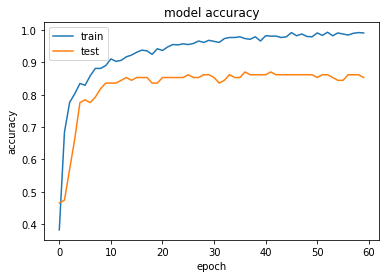

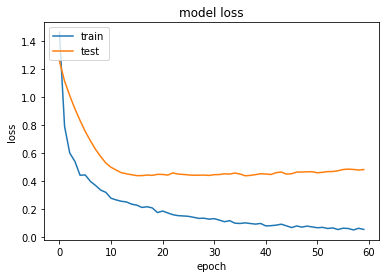

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
epochs = range(len(history.history['accuracy']))
plt.plot(epochs,history.history['accuracy'])

plt.plot(epochs,history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epochs,history.history['loss'])
plt.plot(epochs,history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing with test_data

In [ ]:
import tensorflow.math as tfmath
import tensorflow.keras.backend as tfbackend

model=tf.keras.models.load_model('/content/drive/MyDrive/models/model37.h5')
a=model.predict(test_features)

class_num = tfmath.argmax(a, axis= 1)
print(class_num)

eval_value = tfbackend.eval(class_num)
print("class num eval===",eval_value)

labels = decode_onehot_labels(eval_value)
print("labels")
print(original_test_labels,labels)


tf.Tensor([0 0 2 3 0 1 3 0 1 1 1 2 0 0 0 1 0 2 2 0 1 0], shape=(22,), dtype=int64)
class num eval=== [0 0 2 3 0 1 3 0 1 1 1 2 0 0 0 1 0 2 2 0 1 0]
labels
['purpose' 'purpose' 'aesthetic' 'none' 'craftsmanship' 'craftsmanship'
 'none' 'purpose' 'craftsmanship' 'aesthetic' 'aesthetic' 'aesthetic'
 'purpose' 'purpose' 'purpose' 'craftsmanship' 'purpose' 'craftsmanship'
 'aesthetic' 'purpose' 'purpose' 'purpose'] ['purpose' 'purpose' 'aesthetic' 'none' 'purpose' 'craftsmanship' 'none'
 'purpose' 'craftsmanship' 'craftsmanship' 'craftsmanship' 'aesthetic'
 'purpose' 'purpose' 'purpose' 'craftsmanship' 'purpose' 'aesthetic'
 'aesthetic' 'purpose' 'craftsmanship' 'purpose']


In [ ]:
#Saving the tokenizer
with open('/content/drive/MyDrive/models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Defining Model using transfer learning

In [ ]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
train_label= label_encoder.fit_transform(rand_labels[:921]) 
test_labels= label_encoder.fit_transform(rand_labels[1059-22:1059])
#print(train_label)
print(rand_labels[1059-22:1059])
print(test_labels)
class_arr = np.array([
    "aesthetic", 
    "craftsmanship", 
    "none",
    "purpose"
])
def decode_labels(class_idx):
    return class_arr[class_idx]


['aesthetic' 'aesthetic' 'craftsmanship' 'purpose' 'purpose' 'purpose'
 'purpose' 'purpose' 'craftsmanship' 'craftsmanship' 'purpose'
 'craftsmanship' 'aesthetic' 'aesthetic' 'craftsmanship' 'none'
 'craftsmanship' 'craftsmanship' 'purpose' 'aesthetic' 'purpose' 'purpose']
[0 0 1 3 3 3 3 3 1 1 3 1 0 0 1 2 1 1 3 0 3 3]


In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(multi_class='ovr', solver='liblinear')
lr_clf.fit(train_data[0],train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
a=lr_clf.predict(test_data[0])
print(decode_labels(a))
print(rand_labels[1059-22:1059])

['aesthetic' 'aesthetic' 'craftsmanship' 'purpose' 'aesthetic' 'purpose'
 'purpose' 'purpose' 'craftsmanship' 'craftsmanship' 'purpose'
 'craftsmanship' 'aesthetic' 'aesthetic' 'craftsmanship' 'none'
 'aesthetic' 'craftsmanship' 'purpose' 'aesthetic' 'purpose' 'purpose']
['aesthetic' 'aesthetic' 'craftsmanship' 'purpose' 'purpose' 'purpose'
 'purpose' 'purpose' 'craftsmanship' 'craftsmanship' 'purpose'
 'craftsmanship' 'aesthetic' 'aesthetic' 'craftsmanship' 'none'
 'craftsmanship' 'craftsmanship' 'purpose' 'aesthetic' 'purpose' 'purpose']


In [ ]:
lr_clf.(test_features, test_labels)